In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets
import pymorphy2
import re
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [1]:
nltk.download('punkt')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Код обработки датасета в ноутбуке уже был задан. Наша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [4]:
df = pd.read_csv('df_clean.csv')

In [5]:
df.head()

,address,name,rubrics,aspects,target,text,region,cleaned_text,sym_len,word_len,...,adverbs_count,adjectives_count,punctuation_count,specific_punctuation_count,uppercase_letters_count,uppercase_words_count,rare_words,frequent_words,rare_words_sum,frequent_words_sum
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,Жилой комплекс,квартал лето ночь гонка стройка окно этаж райо...,1,Московский квартал 2.Шумно : летом по ночам ди...,Свердловская область,московский квартал шумно лето ночь дикий гонка...,432,55,...,9,9,30,13,13,1,[],"['большой', 'очень', 'время', 'работать', 'плю...",0,9
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,Магазин продуктов;Продукты глубокой заморозки;...,сеть магазин ассортимент цена главное качество...,2,"Замечательная сеть магазинов в общем, хороший ...",Москва,замечательный сеть магазин общий хороший ассор...,124,15,...,0,4,11,7,2,0,[],"['магазин', 'общий', 'хороший', 'цена', 'качес...",0,6
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,Фитнес-клуб,правило шкаф замочка отпечаток палец дичь подп...,0,"Не знаю смутят ли кого-то данные правила, но я...",Краснодарский край,знать смутить дать правило удивить хотеть твой...,351,44,...,1,7,17,9,8,0,"['замыкаться', 'графа']","['знать', 'дать', 'хотеть', 'купить', 'свой', ...",2,15
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,Пункт проката;Прокат велосипедов;Сапсёрфинг,условие аренда персонал ботинок крепление сноу...,2,Хорошие условия аренды. Дружелюбный персонал.Н...,Санкт-Петербург,хороший условие аренда дружелюбный персонал бы...,107,13,...,0,4,3,0,4,0,['неутоюбный'],"['хороший', 'персонал']",1,2
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,"Салон красоты;Визажисты, стилисты;Салон бровей...",топ топ смысл посещение бровь ресница итог раб...,2,Топ мастер Ангелина топ во всех смыслах ) Немн...,Тверская область,мастер ангелина весь смысл немного волноваться...,263,33,...,3,3,15,6,8,0,[],"['мастер', 'весь', 'первый', 'делать', 'понрав...",0,11


In [6]:
# import seaborn as sns
# df['target'] = df['target'].map({0: 'Негативный', 1: 'Нейтральный', 2: 'Позитивный'})
# df = df.sort_values(by='target')

# # Создайте красивую гистограмму
# plt.figure(figsize=(6, 6))
# sns.countplot(x='target', data=df, palette='gray')

# # Подписи и заголовок
# plt.xlabel('Метки Классов', fontsize=12)
# plt.ylabel('Количество', fontsize=12)
# plt.title('Распределение Классов', fontsize=16)

# # Вывод графика
# plt.show()

In [7]:
data = df[['cleaned_text', 'target']].copy()
data['label'] = data['target']

In [8]:
train_data, eval_data = train_test_split(data, test_size=0.3, random_state=42)

In [9]:
words = Counter()

for example in tqdm(train_data['cleaned_text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))
    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/82753 [00:00<?, ?it/s]

Размер словаря: 8162


In [10]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data.iloc[idx]['cleaned_text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data.iloc[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)
    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)
        new_batch.append(sequence['text'])
    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [11]:
def seed_torch(seed):   # Будем использовать эту функцию вместо просто np.random.seed чтобы уж совсем все проинициализировать
#  random.seed(seed)
#  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

In [12]:
train_dataset = WordDataset(train_data)

In [13]:
len(eval_data)

35466

In [14]:
seed_torch(42)
idx = np.random.choice(np.arange(len(eval_data)), 35466, replace=False)    
eval_dataset = WordDataset(eval_data.iloc[idx])                                                                                

batch_size = 64
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [17]:
from sklearn.metrics import f1_score

def evaluate(model, eval_dataloader, num_classes = 3):
    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    f1_micro = f1_score(target.cpu().numpy(), predictions.cpu().numpy(), average='weighted')
    return f1_micro


## Архитектура модели

In [18]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 3,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)   # если bidirectional=True то размер надо удвоить
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        output = self.dropout(self.linear(output))  # [batch_size, hidden_dim]

        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [19]:
model = CharLM(hidden_dim=512, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.AdamW(model.parameters())

In [20]:
num_epoch = 10

losses_type = {}
acc_type = {}
losses_val_type = {}
predicted_values_type = {}


for aggregation_type in ['max','mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    losses_val = []
    acc = []
    predicted_values_type[aggregation_type] = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        acc_epoch = evaluate(model, eval_dataloader)
        predicted_values_type[aggregation_type].append(acc_epoch)
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        model.eval()
#

        acc.append(evaluate(model, eval_dataloader))
        model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

        epoch_losses_val = []
        model.eval()
        with torch.no_grad():
            for batch_val in eval_dataloader:
                logits = model(batch_val['input_ids'])
                loss = criterion(logits, batch_val['label'])
                epoch_losses_val.append(loss.item())
        model.train()
        losses_val.append(sum(epoch_losses_val) / len(epoch_losses_val))



    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc
    losses_val_type[aggregation_type] = losses_val

Starting training for max


Training epoch 0::   0%|          | 0/1294 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1294 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1294 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1294 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1294 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1294 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/1294 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/1294 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/1294 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/1294 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/1294 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1294 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1294 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1294 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1294 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1294 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/1294 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/1294 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/1294 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/1294 [00:00<?, ?it/s]

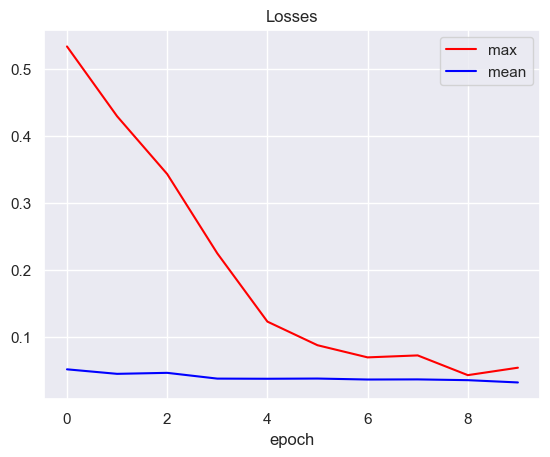

In [21]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 79.16
Лучшая accuracy для подхода mean: 77.25


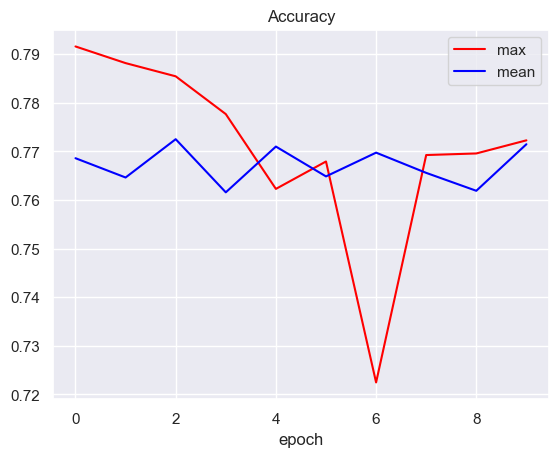

In [22]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name])), acc_type[name], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [23]:
def plot_losses(aggregation_type='mean'):
    x = [ep for ep in range(1, len(losses_type[aggregation_type])+1)]
    plt.plot(x, losses_type[aggregation_type], label='train', color='blue')
    plt.plot(x, losses_val_type[aggregation_type], label='val', color='red')
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title('Loss')
    plt.legend()
    plt.show()


In [25]:
from sklearn.metrics import confusion_matrix

In [26]:
for aggregation_type in ['mean']:
    y_true = []  # Список истинных меток
    y_pred = []  # Список предсказанных меток

    for batch_val in eval_dataloader:
        logits = model(batch_val['input_ids'])
        predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()
        true_labels = batch_val['label'].cpu().numpy()

        y_true.extend(true_labels)
        y_pred.extend(predicted_labels)

    cm = confusion_matrix(y_true, y_pred)

Confusion matrix, without normalization
Normalized confusion matrix


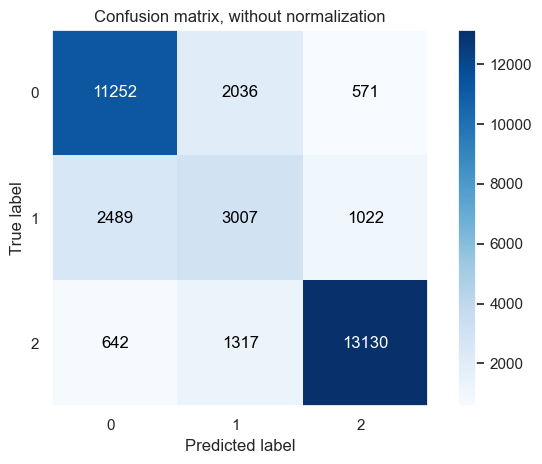

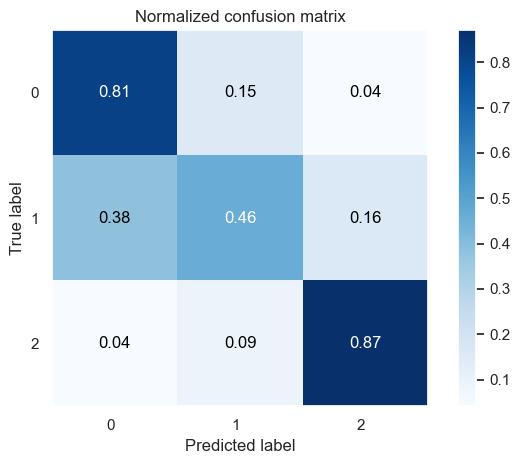

In [27]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred)]
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")
    
    ax.grid(False)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


class_names = np.arange(len(np.unique(y_true)))
plot_confusion_matrix(y_true, y_pred, classes=class_names, title='Confusion matrix, without normalization')
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')

plt.show()
